In [9]:
import json
import sys
import cv2
import numpy as np
import math
import os, sys, shutil
import argparse
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os, sys, shutil

In [10]:
class Point(object):
    def __init__(self, x, y, c):
        self.x = x     # x_coordinate of the point
        self.y = y     # y_coordinate of the point
        self.c = c     # confidence of the point

    def __repr__(self):
        return 'x: '+ str(self.x) + ", y: " +str(self.y) + ", c: " + str(self.c)

### Get input video json directories
Append directories to list

In [14]:

base_dir = '../data_frames/MVI_8191_JSON/'
json_dirs = ['../data_frames/MVI_8191_JSON/{}/'.format(i) for i in os.listdir(base_dir)]

list_of_items = []
for dir in json_dirs:
    list_of_items.append(sorted(os.listdir(dir)))
    
print(list_of_items[0])

['video_29203_29237_000000000000_keypoints.json', 'video_29203_29237_000000000001_keypoints.json', 'video_29203_29237_000000000002_keypoints.json', 'video_29203_29237_000000000003_keypoints.json', 'video_29203_29237_000000000004_keypoints.json', 'video_29203_29237_000000000005_keypoints.json', 'video_29203_29237_000000000006_keypoints.json', 'video_29203_29237_000000000007_keypoints.json', 'video_29203_29237_000000000008_keypoints.json', 'video_29203_29237_000000000009_keypoints.json', 'video_29203_29237_000000000010_keypoints.json', 'video_29203_29237_000000000011_keypoints.json', 'video_29203_29237_000000000012_keypoints.json', 'video_29203_29237_000000000013_keypoints.json', 'video_29203_29237_000000000014_keypoints.json', 'video_29203_29237_000000000015_keypoints.json', 'video_29203_29237_000000000016_keypoints.json', 'video_29203_29237_000000000017_keypoints.json', 'video_29203_29237_000000000018_keypoints.json', 'video_29203_29237_000000000019_keypoints.json', 'video_29203_29237_

### Read Json Files

In [15]:
json_arrays = []

# read jsons of 1st video
for item_index in range(len(list_of_items)):
    
    json_temp = []
    for json_file in list_of_items[item_index]:
        with open(json_dirs[item_index] + json_file) as file:
            json_data = json.loads(file.read())
            json_temp.append(json_data)
            
    json_arrays.append(json_temp)

### Extract Features
<br>
<br>
<div class="row" style="content: "";
  clear: both;
  display: table;">
  <div class="column">
        <img src="https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/doc/media/keypoints_pose_25.png" style="float: left;
  width: 30%;
  padding: 5px;">
    </div>
    <div class="column">
        <img src="https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/doc/media/keypoints_hand.png" style="float: right;
  width: 40%;
  padding: 5px;">
    </div>
</div>

<img src="https://github.com/CMU-Perceptual-Computing-Lab/openpose/raw/master/doc/media/keypoints_face.png" style="
  width: 50%;">

In [16]:
result_arrs = []
label_arrs = []

for json_arr in json_arrays:
    result_arr = []
    label_arr = []
    for json in range(0, len(json_arr)):
        person = json_arr[json]['people'][0]
        pose = person['pose_keypoints_2d']
        face = person['face_keypoints_2d']
        left_hand = person['hand_left_keypoints_2d']
        right_hand = person['hand_right_keypoints_2d']

        ########## EXTRACT POSE POINTS  ##########
        i = 0
        pose_points = []
        for i in range(0, len(pose), 3):
            temp = Point(pose[i],pose[i+1],pose[i+2])
            pose_points.append(temp)    # add this point to pose point array

        ########## EXTRACT FACE POINTS  ##########
        i = 0
        face_points = []
        for i in range(0, len(face), 3):
            temp = Point(face[i],face[i+1],face[i+2])
            face_points.append(temp)    # add this point to pose point array
            i+=3

        ########## EXTRACT LEFT HAND POINTS  ##########
        i = 0
        lhand_points = []
        for i in range(0, len(left_hand), 3):
            temp = Point(left_hand[i],left_hand[i+1],left_hand[i+2])
            lhand_points.append(temp)    # add this point to pose point array
            i+=3


        ########## EXTRACT RIGHT HAND POINTS  ##########
        i = 0
        rhand_points = []
        for i in range(0, len(right_hand), 3):
            temp = Point(right_hand[i],right_hand[i+1],right_hand[i+2])
            rhand_points.append(temp)    # add this point to pose point array
            i+=3

        # neck: 1, nose: 0,
        # left: 4, right: 7
        
        threshold = 0.01

        # CALCULATE MOUTH SHAPE
        mouth_left = math.sqrt((math.pow(face_points[61].x-face_points[67].x,2)+math.pow(face_points[61].y-face_points[67].y,2)))
        mouth_mid = math.sqrt((math.pow(face_points[62].x-face_points[66].x,2)+math.pow(face_points[62].y-face_points[66].y,2)))
        mouth_right = math.sqrt((math.pow(face_points[63].x-face_points[65].x,2)+math.pow(face_points[63].y-face_points[65].y,2)))
        mouth_horizontal = math.sqrt((math.pow(face_points[60].x-face_points[64].x,2)+math.pow(face_points[60].y-face_points[64].y,2)))

        if rhand_points[4].c < threshold:
            r_thumb = 0

        if rhand_points[8].c < threshold:
            r_index = 0

        if rhand_points[12].c < threshold:
            r_middle = 0

        if rhand_points[16].c < threshold:
            r_ring = 0

        if rhand_points[20].c < threshold:
            r_pinky = 0

        # CALCULATE LEFT DISTANCE
        left_to_neck = math.sqrt((math.pow(pose_points[4].x-pose_points[1].x,2)+math.pow(pose_points[4].y-pose_points[1].y,2)))
        left_to_nose = math.sqrt((math.pow(pose_points[4].x-pose_points[0].x,2)+math.pow(pose_points[4].y-pose_points[0].y,2)))

        if pose_points[4].c < threshold:
            left_to_neck = 0
            left_to_nose = 0

        # CALCULATE RIGHT DISTANCE
        right_to_neck = math.sqrt((math.pow(pose_points[7].x-pose_points[1].x,2)+math.pow(pose_points[7].y-pose_points[1].y,2)))
        right_to_nose = math.sqrt((math.pow(pose_points[7].x-pose_points[0].x,2)+math.pow(pose_points[7].y-pose_points[0].y,2)))
        if pose_points[4].c < threshold:
            right_to_neck = 0
            right_to_nose = 0

        # CALCULATE LEFT FINGERS
        l_thumb = math.sqrt((math.pow(lhand_points[4].x-lhand_points[0].x,2)+math.pow(lhand_points[4].y-lhand_points[0].y,2)))
        l_index = math.sqrt((math.pow(lhand_points[8].x-lhand_points[0].x,2)+math.pow(lhand_points[8].y-lhand_points[0].y,2)))
        l_middle = math.sqrt((math.pow(lhand_points[12].x-lhand_points[0].x,2)+math.pow(lhand_points[12].y-lhand_points[0].y,2)))
        l_ring = math.sqrt((math.pow(lhand_points[16].x-lhand_points[0].x,2)+math.pow(lhand_points[16].y-lhand_points[0].y,2)))
        l_pinky = math.sqrt((math.pow(lhand_points[20].x-lhand_points[0].x,2)+math.pow(lhand_points[20].y-lhand_points[0].y,2)))

        if lhand_points[4].c < threshold:
            l_thumb = 0

        if lhand_points[8].c < threshold:
            l_index = 0

        if lhand_points[12].c < threshold:
            l_middle = 0

        if lhand_points[16].c < threshold:
            l_ring = 0

        if lhand_points[20].c < threshold:
            l_pinky = 0


        # CALCULATE RIGHT FINGERS
        r_thumb = math.sqrt((math.pow(rhand_points[4].x-rhand_points[0].x,2)+math.pow(rhand_points[4].y-rhand_points[0].y,2)))
        r_index = math.sqrt((math.pow(rhand_points[8].x-rhand_points[0].x,2)+math.pow(rhand_points[8].y-rhand_points[0].y,2)))
        r_middle = math.sqrt((math.pow(rhand_points[12].x-rhand_points[0].x,2)+math.pow(rhand_points[12].y-rhand_points[0].y,2)))
        r_ring = math.sqrt((math.pow(rhand_points[16].x-rhand_points[0].x,2)+math.pow(rhand_points[16].y-rhand_points[0].y,2)))
        r_pinky = math.sqrt((math.pow(rhand_points[20].x-rhand_points[0].x,2)+math.pow(rhand_points[20].y-rhand_points[0].y,2)))

        if rhand_points[4].c < threshold:
            r_thumb = 0

        if rhand_points[8].c < threshold:
            r_index = 0

        if rhand_points[12].c < threshold:
            r_middle = 0

        if rhand_points[16].c < threshold:
            r_ring = 0

        if rhand_points[20].c < threshold:
            r_pinky = 0

        
        temp_arr1 = [left_to_neck, left_to_nose, right_to_neck, right_to_nose, l_thumb, l_index, l_middle, l_ring, l_pinky, r_thumb, r_index, r_middle, r_ring, r_pinky]

        temp_arr2 = [left_to_neck, left_to_nose, l_thumb, l_index, l_middle, l_ring, l_pinky, mouth_left, mouth_mid, mouth_right, mouth_horizontal]

        temp_arr3 = [left_to_neck, left_to_nose, right_to_neck, right_to_nose]
        
        temp_arr4 = [left_to_neck, left_to_nose, l_thumb, l_index, l_middle, l_ring, l_pinky]
        
        temp_arr5 = [left_to_neck, left_to_nose]

        # decide which feature vector to work
        result_arr.append(temp_arr4)
        label_arr.append(json)
        
    result_arrs.append(result_arr)
    label_arrs.append(label_arr)
    

### Apply Interpolation

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/LinearInterpolation.svg/1200px-LinearInterpolation.svg.png" width="25%">

In [17]:
for k in range(len(result_arrs)):
    for feature in range(len(result_arrs[0][0])):
        for index in range(len(result_arrs[k])):
            value = result_arrs[k][index][feature]

            if value == 0:
                for next_index in range(index + 1, len(result_arrs[k])):
                    next_value = result_arrs[k][next_index][feature]

                    if(next_value != 0):
                        linear_down_val = result_arrs[k][index - 1][feature]
                        linear_up_val = result_arrs[k][next_index][feature]

                        linear_index_diff = next_index - (index - 1)
                        linear_val_diff_per_index = (linear_up_val - linear_down_val) / linear_index_diff

                        for fix_index in range(index, next_index):
                            linear_down_val += linear_val_diff_per_index
                            result_arrs[k][fix_index][feature] = linear_down_val

                        break
    

#### Handle zeros

In [18]:
point_errors = []
for result_arr in result_arrs:
    point_error = []
    for feature in range(len(result_arr[0])):
        for index in range(len(result_arr)):
            if result_arr[index][feature] == 0:
                point_error.append(index)
                break
                
    point_errors.append(point_error)

In [19]:
print(point_errors)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [234, 234, 234], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [69], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [20]:
result_arrs = np.asarray(result_arrs)
label_arrs = np.asarray(label_arrs)

for i in range(len(result_arrs)):
    result_arrs[i] = np.asarray(result_arrs[i])


for i in range(len(point_errors)):
    if(len(point_errors[i]) != 0):
        slice_point = min(point_errors[i])

        label_arrs[i] = label_arrs[i][0:slice_point]
        result_arrs[i] = result_arrs[i][0:slice_point]

#### Print shape of json arrays

In [21]:
print(len(result_arrs[0]))
print(len(result_arrs[1]))
print(len(result_arrs[2]))

35
23
129


In [ ]:
for result_arr in result_arrs:
    x_axis = result_arr[:,0]  # left distance
    y_axis = result_arr[:,1]  # right distance

    # Plotting
    plt.scatter(x_axis, y_axis)
    plt.show()

### Apply Normalization

In [ ]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [ ]:
def normalize2(arr):
    max_value = max([max(arr[i]) for i in range(len(arr))])
    min_value = min([min(arr[i]) for i in range(len(arr))])
    d = (arr-min_value) / (max_value - min_value)
    return d

In [ ]:
#for i in range(len(result_arrs)):
#    result_arrs[i] = normalize2(result_arrs[i])

### Plot json sizes

ValueError: shape mismatch: objects cannot be broadcast to a single shape

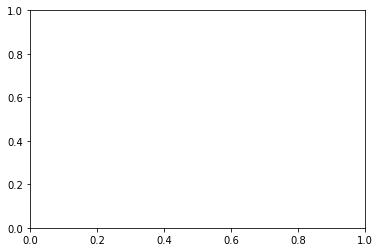

In [22]:
bars = ('hayir1', 'hayir2', 'hayir3')
y_pos = np.arange(len(bars))
heights = []
for i in range(len(result_arrs)):
    heights.append(len(result_arrs[i]))
    
# Create bars
plt.bar(y_pos, heights)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)
 
# Show graphic
plt.show()


# Dynamic Time Warping

<img src="https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F13+.png" width="100%">

In [23]:
import os
import sys
import numpy as np
import scipy.spatial
import librosa
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.ticker import FuncFormatter

sys.path.append('..')
%matplotlib inline

ImportError: No module named librosa

In [ ]:
video1 = result_arrs[0][95:120]
video2 = result_arrs[2]

In [ ]:
plt.plot(video1,'b', label='x')
plt.plot(video2, 'r', label='y')
plt.legend();

In [ ]:
C = scipy.spatial.distance.cdist(video1, video2, 'sqeuclidean')
print('Cost matrix C =', C, sep='\n')

### Compute Accumulated Cost Matrix
Given the cost matrix, compute the accumulated cost matrix for subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        C: cost matrix

    Returns:
        D: Accumulated cost matrix

In [ ]:
@jit(nopython=True)
def compute_accumulated_cost_matrix(C):
    N, M = C.shape
    D = np.zeros((N, M))
    D[:, 0] = np.cumsum(C[:, 0])
    D[0, :] = C[0, :]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D =  compute_accumulated_cost_matrix(C)
print('b* =', D[-1, :].argmin())

### Compute Optimal Warping Path
Given an accumulated cost matrix, Compute the warping path for subsequence dynamic time warping with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        D: Accumulated cost matrix

    Returns
        P: Warping path (list of index pairs)

In [ ]:
@jit(nopython=True)
def compute_optimal_warping_path(D):
    N, M = D.shape
    n = N - 1
    m = D[N - 1, :].argmin()
    P = [(n, m)]

    while n > 0:
        if m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        n, m = cell
    P.reverse()
    return np.array(P)
        
P = compute_optimal_warping_path(D)
path = P.tolist()
print('Optimal warping path P =', path)

In [ ]:
print("We find the sign in the following range of the video: "+str(path[0][1])+" - "+str(path[len(path)-1][1]))

In [ ]:
x = []
y = []
for i in range(len(path)):
    x.append(path[i][0])
    y.append(path[i][1])

from matplotlib import pyplot as plt

plt.plot(x,y)
plt.show()